In [1]:
import numpy as np
import typing
from dataclasses import dataclass
from int_field import ZSqrt2Int

In [2]:

# implement ellipse as a 2x2 matrix using ZSqrt2Int as entries
# but we are storing the grid operator and ellipse differently and should make sure to track that in our mind


def skew(d, delta):
    assert np.isclose(d[0, 1], d[1, 0])
    assert np.isclose(delta[0, 1], delta[1, 0])
    
    b = d[0, 1]
    beta = delta[1, 0]
    
    return b**2 + beta**2


def compute_parameters(M):
    """Computes z, e, b from ellipse matrix M.

    Args:
        M (Matrix): 2x2 matrix representing an ellipse

    Returns:
        int, int, int: z, e, b
    """
    # TODO: change everything relying on z to instead use e^z because logarithms are expensive
    assert np.isclose(M[0, 1], M[1, 0])
    constant_lambda = 1 + np.sqrt(2)
    z = np.log(M[1, 1] / M[0, 0]) / (2 * np.log(constant_lambda))
    
    e = M[0, 0] / (constant_lambda**(- z))
    b = M[0, 1]
    
    assert np.isclose(M[0, 0], e * constant_lambda**(-z)), (M[0, 0], M[1, 1], e * constant_lambda**(-z), e, z)
    assert np.isclose(M[1, 1], e * constant_lambda**z), (M[0, 0], M[1, 1], e * constant_lambda**z, e, z)
    
    return z, e, b


def bias(d, delta):
    z, _, _ = compute_parameters(d)
    zeta, _, _ = compute_parameters(delta)
    
    return zeta - z

def eval_mat_zsq2(M):
    return np.array([[x.eval() for x in row] for row in M])

def apply(G, d, delta):
    """Applies an operator G to the d, delta pair.

    Args:
        G (operator): matrix operator
        d (matrix): d matrix
        delta (matrix): delta matrix

    Returns:
        d', delta': matrix pair
    """
    # Definition A.3
    
    Gbul = np.array([
        [~G[0, 0], ~G[0, 1]],
        [~G[1, 0], ~G[1, 1]]
    ])
    
    val_G = eval_mat_zsq2(G)
    val_Gbul = eval_mat_zsq2(Gbul)
    
    d_prime = val_G.T @ d @ val_G
    delta_prime = val_Gbul.T @ delta @ val_Gbul
    
    return d_prime, delta_prime

In [3]:
ZSqrt2Int((1, 1)) * ZSqrt2Int((1, -1))

ZSqrt2Int((-1, 0))

In [8]:
one = ZSqrt2Int((1, 0))
zero = ZSqrt2Int((0, 0))
sqrt2 = ZSqrt2Int((0, 1))
lam = ZSqrt2Int((1, 1))

R = np.array([
    [one, one * -1], 
    [one, one]
])

K = np.array([
    [~lam, one * -1],
    [lam, one]
])

K_bul = np.array([[~x for x in row] for row in K])

A = np.array([
    [one, one * -2], 
    [zero, one],
])

X = np.array([
    [zero, one], 
    [one, zero],
])

B = np.array([
    [one, sqrt2], 
    [zero, one],
])

Z = np.array([
        [one, zero],
        [zero, one * -1]
])

sigma = np.array([
    [lam, zero],
    [zero, one]
])

tau = np.array([
    [one, zero],
    [zero, lam * -1]
])


def compute_ginverse(G):
    """Given special grid operator, find its inverse

    Args:
        G (matrix of ZSq2): grid operator in G\sqrt{2} representation
    """
    
    # check that G is special, i.e. has determinant +/- 1
    
    a = G[0, 0]
    b = G[0, 1]
    c = G[1, 0]
    d = G[1, 1]
    
    det = a * d - b * c
    assert abs(det.eval()) == 2 # determinant should be +- 2 because of sqrt(2) factor
    det = det[0]
    
    # inverse of 2x2 matrix takes the following form:
    # 1/det * [[d, -b], [-c, a]]
    # so inv(G \sqrt{2}) = 1/sqrt(2) * inv(G)
    # so inv(G) = sqrt(2) * inv(G \sqrt{2})
    
    return np.array([
        [d, b * -1],
        [c * -1, a]
    ]) * det * ZSqrt2Int((0, 1)) / 2
    # we can muliply by det because it is +- 1


def find_grid_operator(d, delta):
    G = np.array([
        [one, zero],
        [zero, one]
    ])
    
    G *= ZSqrt2Int((0, 1)) # we store the G \sqrt{2} representation
    
    z, e, b = compute_parameters(d)
    zeta, eps, beta = compute_parameters(delta)
    
    while skew(d, delta) >= 15:
        old_skew = skew(d, delta)
        print("skew", skew(d, delta))
        add_G, d, delta = step_find_grid_operator(d, delta)
        new_skew = skew(d, delta)
        assert new_skew < old_skew, (new_skew, old_skew)
        
        G = G @ add_G
        G = G * ZSqrt2Int((0, 1)) / 2
    
    return G, d, delta


def step_find_grid_operator(d, delta):
    constant_lambda = 1 + np.sqrt(2)
    grid_operator = np.array([
        [one, zero],
        [zero, one]
    ])
    
    grid_operator *= ZSqrt2Int((0, 1))
    
    z, e, b = compute_parameters(d)
    zeta, eps, beta = compute_parameters(delta)
    
    fix_bias = False
    # fix bias
    if np.abs(bias(d, delta)) > 1:
        fix_bias = True
        # Lemma A.1
        shift_k = np.floor((1 - bias(d, delta)) / 2)
        print("Shift k", shift_k)
        
        sigma_k = np.array([
            [lam**shift_k, zero],
            [zero, one]
        ])
        tau_k = np.array([
            [one, zero],
            [zero, (lam * -1)**shift_k]
        ])
        
        leading_factor = lam**(-shift_k)
        d = sigma_k @ d @ sigma_k * leading_factor
        delta = tau_k @ delta @ tau_k * leading_factor
    
    if beta < 0:
        grid_operator = grid_operator @ Z
        d, delta = apply(Z, d, delta)
    
    if z + zeta < 0:
        grid_operator = grid_operator @ X
        d, delta = apply(X, d, delta)
    
    z, e, b = compute_parameters(d)
    zeta, eps, beta = compute_parameters(delta)
    
    assert np.abs(bias(d, delta)) <= 1, (bias(d, delta), d, delta)
    assert beta >= 0
    assert z + zeta >= 0
    assert skew(d, delta) >= 15
    
    if b >= 0:
        if -0.8 <= z <= 0.8 and -0.8 <= zeta <= 0.8:
            print("R")
            grid_operator = grid_operator @ R * ZSqrt2Int((0, 1))
            grid_operator = grid_operator / 2
            
            d, delta = apply(R, d, delta)
            d = d / 2
            delta = delta / 2
            
        elif z <= 0.3 and 0.8 <= zeta:
            print("K")
            grid_operator = grid_operator @ K * ZSqrt2Int((0, 1))
            grid_operator = grid_operator / 2
            
            d, delta = apply(K, d, delta)
            d = d / 2
            delta = delta / 2
        elif 0.3 <= z and 0.3 <= zeta:
            print("A")
            assert b >= 0 and beta >= 0, (b, beta)
            # Lemma A.17
            c = min(z, zeta)
            n = int(max(1, np.floor(constant_lambda**c / 2)))
            
            An = np.array([
                [one, one * -2 * n],
                [zero, one]
            ])
            
            grid_operator = grid_operator @ An
            d, delta = apply(An, d, delta)
            
        elif 0.8 <= z and zeta <= 0.3:
            print("K_bul")
            grid_operator = grid_operator @ K_bul * ZSqrt2Int((0, 1))
            grid_operator = grid_operator / 2
            d, delta = apply(K_bul, d, delta)
            d = d / 2
            delta = delta / 2
        else:
            raise ValueError("This should not happen")
    else:
        if -0.8 <= z <= 0.8 and -0.8 <= zeta <= 0.8:
            print("Rb")
            grid_operator = grid_operator @ R * ZSqrt2Int((0, 1))
            grid_operator = grid_operator / 2
            
            d, delta = apply(R, d, delta)
            d = d / 2
            delta = delta / 2
            
        elif z >= -0.2 and zeta >= -0.2:
            print("B")
            c = min(z, zeta)
            n = int(max(1, np.floor(constant_lambda**c / np.sqrt(2))))
            
            Bn = np.array([
                [one, sqrt2 * n],
                [zero, one]
            ])
            
            grid_operator = grid_operator @ Bn
            d, delta = apply(Bn, d, delta)
        else:
            raise ValueError("This should not happen")
    
    # we need to post-adjust bias
    if fix_bias:
        grid_operator = sigma_k @ grid_operator @ sigma_k
    
    return grid_operator, d, delta

In [10]:
grid_operator = np.array([
        [one, zero],
        [zero, one]
    ]) / 2

AssertionError: self=ZSqrt2Int((1, 0)), o=2

In [7]:
ZSqrt2Int((2, 0)) / 2

ZSqrt2Int((1, 0))

In [ ]:
aa = np.array([[ 1., -2.],
       [ 0.,  1.]])

aa.T @ unit_disk @ aa

array([[  8.28427125, -11.56854249],
       [-11.56854249,  61.42135624]])

In [ ]:
test_d, test_delta = apply(A, unit_disk, unit_disk)
print(test_d)
print(skew(test_d, test_delta))
# test_d, test_delta = apply(Z, test_d, test_delta)
# test_d, test_delta = apply(A @ A @ A @ A, test_d, test_delta)
# test_d = test_d / 2
# test_delta = test_delta / 2
print(skew(test_d, test_delta))
compute_parameters(test_d)

[[8.28427125 3.40644186]
 [3.40644186 1.52141882]]
23.207692298129253
23.207692298129253


(-0.9614057992682924, 3.5501895933970533, 3.4064418605143736)

In [ ]:
e = 22389
z = 1
b = np.sqrt(e**2 - 1)

constant_lambda = 1 + np.sqrt(2)
unit_disk = np.array([
    [e * constant_lambda**(-z), b],
    [b, e * constant_lambda**z]
])

assert np.isclose(np.linalg.det(unit_disk), 1), "State must be determinant 1"
Gop, d, delta = find_grid_operator(unit_disk, unit_disk)

skew 1002534640.0
A
skew 29511864.07378806
A
skew 868747.6458793846
A
skew 25573.063599867684
A
skew 752.3144920571426
A
skew 21.66377992363721
A


[[ 4.55634919 10.95445115]
 [10.95445115 26.55634919]]


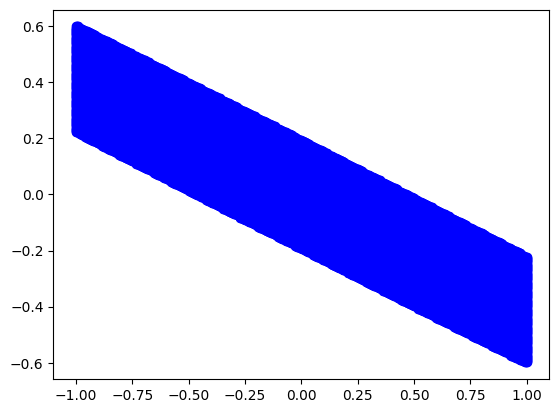

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 500)
y = np.linspace(-1, 1, 500)

e = 11
z = 1
b = np.sqrt(e**2 - 1)

constant_lambda = 1 + np.sqrt(2)
unit_disk = np.array([
    [e * constant_lambda**(-z), b],
    [b, e * constant_lambda**z]
])


# unit_disk_2, _ = apply(A, unit_disk, unit_disk)
# unit_disk_2 = np.array([
#     [(e + 1) * constant_lambda**(-z), b],
#     [b, (e + 1) * constant_lambda**z]
# ])


print(unit_disk)

x_vals = []
y_vals = []

x_vals2 = []
y_vals2 = []

for i in range(len(x)):
    for j in range(len(y)):
        u = np.array([[x[i], y[j]]]).T
        
        val = u.T @ unit_disk @ u
        val2 = u.T @ unit_disk_2 @ u
        
        # print(val)
        if val <= 1:
            x_vals.append(x[i])
            y_vals.append(y[j])
            # pass
            # plt.scatter(x[i], y[j], color='blue')
        
        if val2 <= 1:
            x_vals2.append(x[i])
            y_vals2.append(y[j])

plt.scatter(x_vals, y_vals, color='blue')
# plt.scatter(x_vals2, y_vals2, color='red')

Let's put it all together!

We need to enumerate an ellipse which encloses the region we care about, i.e. the Fallback region. Call this region $D$ and associated $\Delta$ is the bounds on the bullet value.

We then reshape this region via the special grid operator so that we can enumerate the points more rapidly.

We then rapidly enumerate points, translate back to the original region, and discard points which do not lie in the original region.

Finally, we check for solvability.